# Wetterdatenanalyse europäischer Städte

## 1. Einführung
In diesem Notebook analysieren wir Wetterdaten (Temperatur und Luftfeuchtigkeit) von fünf europäischen Städten, die über die Open-Meteo API bezogen wurden.

Ziel ist es, Temperaturverläufe zu vergleichen und mögliche Zusammenhänge mit der Luftfeuchtigkeit zu untersuchen.

**Datenquelle**: [Open-Meteo API](https://open-meteo.com)  
**Städte**: Berlin, Paris, Madrid, Rom, Wien



## 1.1 Bibliotheken importieren

In [ ]:
import os
import sys
import re
import sqlite3
from datetime import datetime

import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from scipy import stats
from scipy.stats import pearsonr

## 2. Daten einlesen & vorbereiten

In [26]:
load_dotenv()
df = pd.read_csv("../data/weather_data_today.csv")
df['datetime'] = pd.to_datetime(df['datetime'])

df.head()


,city,datetime,temperature,humidity
0,Berlin,2025-04-04 00:00:00,12.1,65
1,Berlin,2025-04-04 01:00:00,11.5,65
2,Berlin,2025-04-04 02:00:00,10.5,72
3,Berlin,2025-04-04 03:00:00,10.4,73
4,Berlin,2025-04-04 04:00:00,9.8,76


## 3. Temperaturverlauf über den Tag

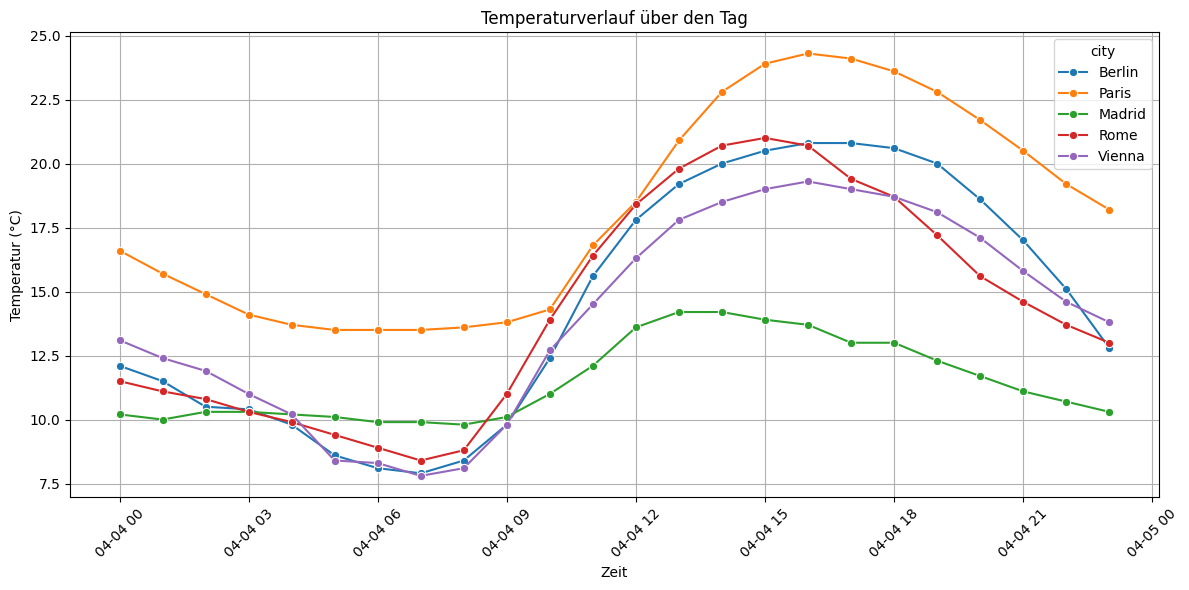

In [27]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="datetime", y="temperature", hue="city", marker="o")
plt.title("Temperaturverlauf über den Tag")
plt.xlabel("Zeit")
plt.ylabel("Temperatur (°C)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


## 4. Durchschnittliche Luftfeuchtigkeit

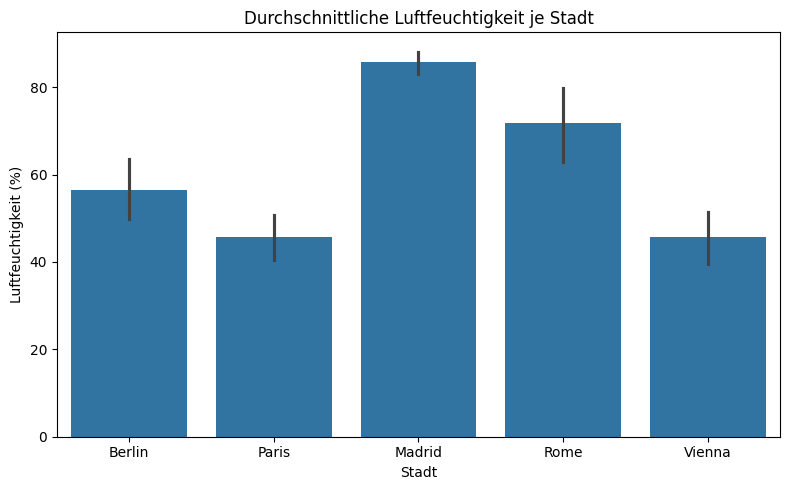

In [28]:
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x="city", y="humidity", estimator='mean')
plt.title("Durchschnittliche Luftfeuchtigkeit je Stadt")
plt.ylabel("Luftfeuchtigkeit (%)")
plt.xlabel("Stadt")
plt.tight_layout()
plt.show()


## 5. Statistische Analyse: Korrelation Temperatur vs. Luftfeuchtigkeit



Wir berechnen die Pearson-Korrelation zwischen Temperatur und Luftfeuchtigkeit über alle Städte hinweg.

Ein p-Wert unter 0.05 weist auf einen signifikanten linearen Zusammenhang hin.


In [29]:
# Korrelationsanalyse zwischen Temperatur und Luftfeuchtigkeit

# Nur Temperatur und Luftfeuchtigkeit
temp = df["temperature"]
humidity = df["humidity"]

# Pearson-Korrelation berechnen
correlation, p_value = pearsonr(temp, humidity)

print(f"Korrelationskoeffizient: {correlation:.2f}")
print(f"p-Wert: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("➡️ Statistisch signifikanter Zusammenhang (p < 0.05)")
else:
    print("➡️ Kein statistisch signifikanter Zusammenhang (p >= 0.05)")


Korrelationskoeffizient: -0.83
p-Wert: 0.0000
➡️ Statistisch signifikanter Zusammenhang (p < 0.05)


## 6. Datenbankanalyse (SQLite)


In [30]:
# Datenbankabfrage
db_path = os.path.abspath(os.path.join(os.path.dirname("__file__"), "../data/weather_data.db"))
conn = sqlite3.connect(db_path)

query = """
SELECT 
    city,
    MIN(temperature) AS min_temp,
    MAX(temperature) AS max_temp,
    AVG(temperature) AS avg_temp
FROM weather
GROUP BY city
ORDER BY avg_temp DESC;
"""

temp_stats_df = pd.read_sql_query(query, conn)
conn.close()

temp_stats_df


,city,min_temp,max_temp,avg_temp
0,Paris,10.0,21.6,15.895833
1,Rome,9.4,21.8,14.895833
2,Vienna,7.8,17.8,12.954167
3,Berlin,5.2,18.6,11.945833
4,Madrid,9.1,12.1,10.658333


/tmp/ipykernel_25324/3800590310.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=temp_stats_df, x="city", y="avg_temp", palette="viridis")


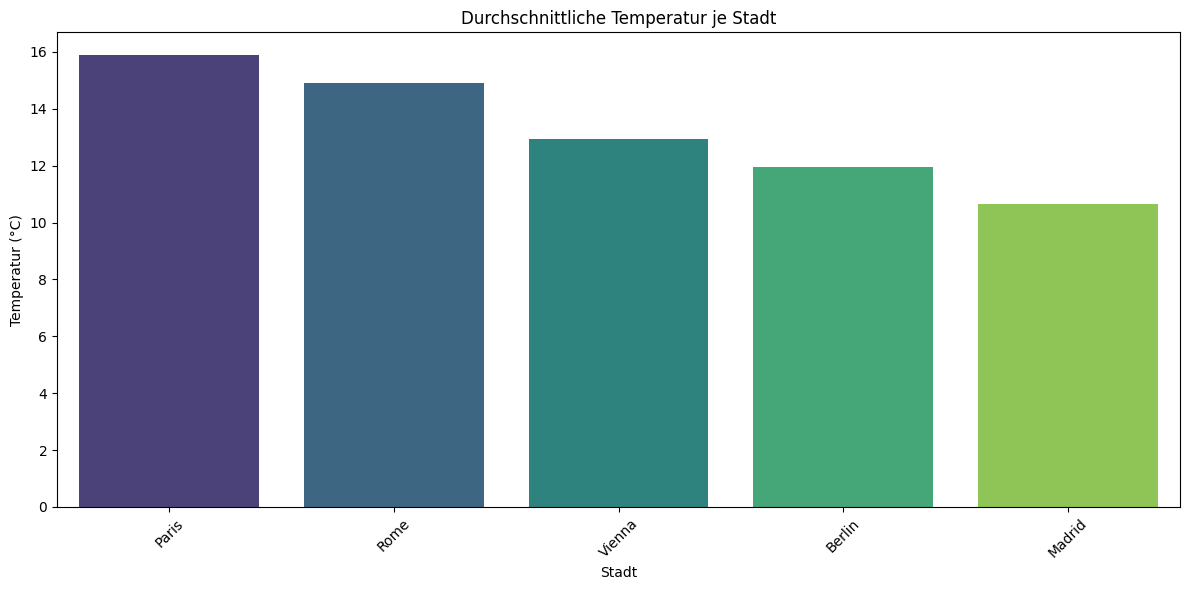

<Figure size 1200x600 with 0 Axes>

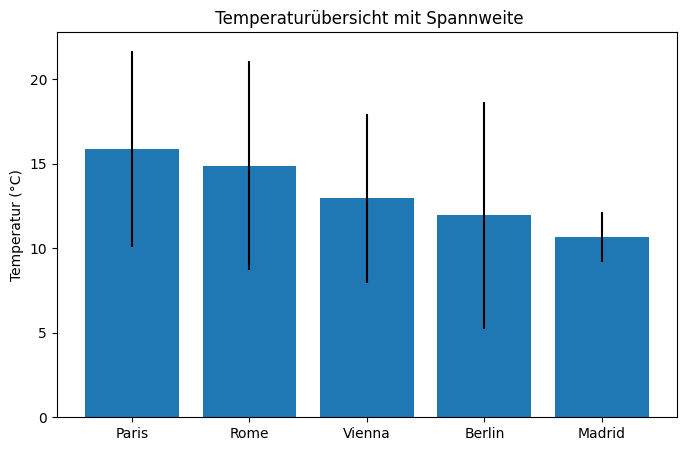

In [31]:
# Visualisierung der Temperaturstatistiken
plt.figure(figsize=(12, 6))
sns.barplot(data=temp_stats_df, x="city", y="avg_temp", palette="viridis")
plt.title("Durchschnittliche Temperatur je Stadt")
plt.ylabel("Temperatur (°C)")
plt.xlabel("Stadt")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Visualisierung der Temperaturstatistiken mit Spannweite
plt.figure(figsize=(12, 6))
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(temp_stats_df['city'], temp_stats_df['avg_temp'], yerr=(temp_stats_df['max_temp'] - temp_stats_df['min_temp']) / 2)
ax.set_ylabel("Temperatur (°C)")
ax.set_title(" Temperaturübersicht mit Spannweite")
plt.show()


## 7. LLM-Analyse

In [33]:
src_path = os.path.abspath(os.path.join(os.getcwd(), "..", "src"))
sys.path.append(src_path)
print(src_path)
from llm_summary import query_local_llm

prompt = """
Fasse die stündlichen Wetterdaten für Berlin, Paris, Madrid, Rom und Wien zusammen.
Die Pearson-Korrelation zwischen Temperatur und Luftfeuchtigkeit beträgt -0.79.
Was bedeutet das?
"""

antwort = query_local_llm(prompt)
print(antwort)


/workspaces/MeHa_project/src
❌ Ausnahme bei LLM-Abfrage: [Errno 2] No such file or directory: 'ollama'
None


## 8. Fazit

Unsere Analyse hat gezeigt, dass die Wetterdaten über die Open-Meteo API erfolgreich gesammelt und analysiert werden konnten. 
Je nach Stadt und Tageszeit zeigten sich klare Unterschiede im Temperaturverlauf.

**Beobachtungen:**
- Temperatur & Luftfeuchtigkeit zeigen starke negative Korrelation
- Paris hat aktuell die höchste Durchschnittstemperatur
- SQLite-Auswertung zeigt Min/Max/Avg je Stadt auf Knopfdruck




## 9. Hinweis auf Web-App (Streamlit)

Optional: In der App kann interaktiv analysiert & exportiert werden  
📍 Datei: `app/streamlit_app.py`
